# Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Loading the processed Data

In [2]:
X_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train.csv')
X_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_test.csv')
y_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train.csv')['Class']
y_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_test.csv')['Class']
X_train_res = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train_res.csv')
y_train_res = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train_res.csv')['Class']

In [3]:
y_train = y_train.ravel()
y_test = y_test.ravel()
y_train_res = y_train_res.ravel()

# Model

## Training on imbalanced data

In [4]:
model = DecisionTreeClassifier(random_state=42,class_weight='balanced')

In [5]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [6]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1',n_jobs=-1)

In [7]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='f1')

In [8]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
Best score: 0.7023257405649241


In [9]:
best_model = random_search.best_estimator_

In [10]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [11]:
y_pred = best_model.predict(X_test)

## Training on balanced data

In [12]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='precision',n_jobs=-1)

In [13]:
random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='precision')

In [14]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
Best score: 0.9968927159381229


In [15]:
best_model = random_search.best_estimator_

In [16]:
best_model.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight='balanced', min_samples_split=10,
                       random_state=42)

In [17]:
y_pred = best_model.predict(X_test)

# Pruning

In [18]:
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [19]:
param_grid = {
    'max_depth': [10,15,20,25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5,8],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': np.linspace(min(ccp_alphas[ccp_alphas > 0]), max(ccp_alphas) / 2, 5)
}

In [20]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='precision',n_jobs=-1)

In [21]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': array([3.90928762e-20, 4.53597697e-02, 9.07195393e-02, 1.36079309e-01,
       1.81439079e-01]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 20, 25],
                                        'min_samples_leaf': [2, 5, 8],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='precision')

In [22]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 25, 'criterion': 'gini', 'ccp_alpha': np.float64(3.9092876213238176e-20)}
Best score: 0.6682207388250095


In [23]:
best_model = random_search.best_estimator_

In [24]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(3.9092876213238176e-20),
                       class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, random_state=42)

In [25]:
y_pred = best_model.predict(X_test)

# Cost Sensitive

In [26]:
param_grid = {
    'max_depth': [ 5,10,15,20],
    'min_samples_split': [1,2,5,10],
    'min_samples_leaf': [1,2,5,8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0: 1, 1: w} for w in [10, 50, 100]]
}

In [27]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1',n_jobs=-1)

In [28]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 10},
                                                         {0: 1, 1: 50},
                                                         {0: 1, 1: 100}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 5, 8],
                                        'min_samples_split': [1, 2, 5, 10]},
                   scoring='f1')

In [29]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 10}}
Best score: 0.8083429450211458


In [30]:
best_model = random_search.best_estimator_

In [31]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                       max_depth=5, min_samples_leaf=5, random_state=42)

In [32]:
y_pred = best_model.predict(X_test)

# Evaluation

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
saved_loss_rate = tp / (tp + fn)

In [34]:
metrics = {
    'Accuracy': float(accuracy),
    'Precision': float(precision),
    'Recall': float(recall),
    'F1-score': float(f1),
    'True Positives': float(tp),
    'False Positives': float(fp),
    'Saved Loss Rate': float(saved_loss_rate),
}
with open('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/costsensitive_metrics.json', 'w') as f:
    json.dump(metrics, f,indent=4)

# pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(30).to_csv('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/pruned_results.csv')

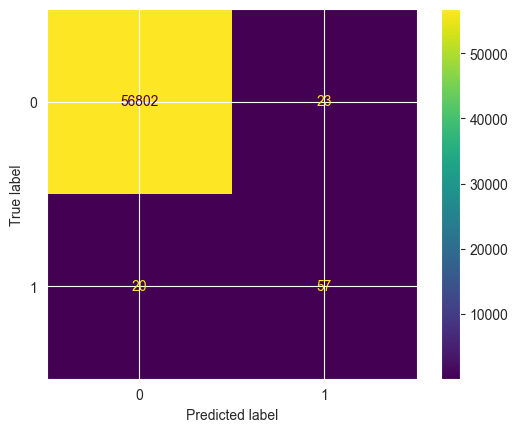

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

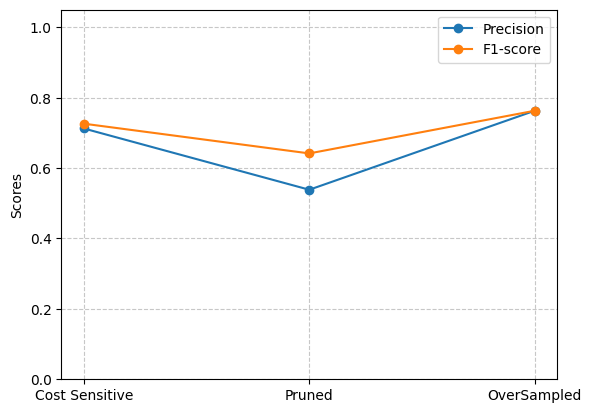

In [8]:
import json
import os
json_files = ['/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/costsensitive_metrics.json', '/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/pruned_metrics.json', '/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/resampled_metrics.json']

reports = {}

for file in json_files:
    model_name = os.path.splitext(file)[0]
    with open(file, 'r') as f:
        reports[model_name] = json.load(f)


models = list(reports.keys())
metrics = ["Precision", "F1-score"]

for metric in metrics:
    values = [reports[model][metric] for model in models]
    plt.plot(models, values, marker='o', label=metric)

plt.ylim(0, 1.05)
plt.xlabel('')
plt.ylabel('Scores')
plt.legend()
plt.xticks(ticks=range(len(models)), labels=['Cost Sensitive','Pruned','OverSampled'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/Users/raya/Desktop/fraud-detection/european-dataset/reports/decision_tree/figures/dt_comparison.png')
plt.show()

